In [50]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from hyperopt import hp
import plotly.graph_objects as go
import plotly.offline as py 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [51]:
employee_df = pd.read_csv("./dataset.csv")
_target_column = "Attrition"

In [52]:
employee_df.drop(columns=["EmployeeNumber"],inplace=True, axis=1)

In [53]:
# Checking nans
employee_df.isna().sum().sum()

0

In [54]:
# checking cloumns that contain single values
single_valued_column = [column for column in employee_df.columns if len(employee_df[column].unique()) < 2]

In [55]:
# droping single valued columns
df = employee_df.drop(columns= single_valued_column, axis=1)

In [56]:
def distribute_data_equally(df, target_column):
    df = df.copy()
    employee_attrition = df[df[target_column] == 1]
    employee_non_attrition = df[df[target_column] != 1] \
                        .sample(n = len(employee_attrition))
    df =  pd.concat([employee_attrition, employee_non_attrition])
    df = df.sample(frac=1).reset_index(drop=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [58]:
# apply label encoding to target column
label_encoder = LabelEncoder()
label_encoder.fit(df[_target_column])
df[_target_column] = label_encoder.transform(df[_target_column])

In [59]:
# feature encoding
object_cols = [col for col, dtype in df.dtypes.items() if dtype == "object" or dtype == "string"]
feature_encoder = OrdinalEncoder()
feature_encoder.fit(df[object_cols])
df[object_cols] = feature_encoder.transform(df[object_cols])

In [60]:
df = distribute_data_equally(df, _target_column)

In [61]:
# check the correlation between target and other columns
def correlation_heatmap(df):
    columns = df.columns
    data = [go.Heatmap(z=df[columns].corr().values,
              x=df[columns].columns.values,
              y=df[columns].columns.values,
              colorscale="Viridis",
              reversescale=False,
              opacity=1.0)]

    layout = go.Layout(
        title='Pearson Correlation of numerical features',
        xaxis = dict(ticks='', nticks=len(columns)),
        yaxis = dict(ticks='' ),
        width = 900, height = 700,
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='labelled-heatmap')
correlation_heatmap(df)

In [62]:
y = df[_target_column]
X = df.drop(_target_column, axis=1)

# split dataset
train_data, test_data, train_labels, test_labels = train_test_split(
    X, y, test_size=0.20, random_state=42)
train_data.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

In [63]:
print(f"Number of rows in train data: {len(train_data)}")
print(f"Number of rows in test data: {len(test_data)}")

Number of rows in train data: 379
Number of rows in test data: 95


# Logistic Regression Model

### Hyperparameter tuning for Logistic Regression

In [71]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [72]:

def tune_logistic_regression(search_space,max_iterations,training_data,training_labels,kfolds=5):
    print("Tuning Hyper-parameter for Logistic Regression")
    def objective(search_space):
        model = LogisticRegression(**search_space)
        cv_results = cross_val_score(model, X=training_data, y=training_labels, cv=kfolds,scoring="accuracy")
        accuracy = cv_results.mean()    
        return {"loss":(1-accuracy),"status":STATUS_OK}
    
    best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=max_iterations)    
    print("Tuning completed")
    return best_params


In [74]:
# Define search space for Logistic Regression model.
search_space = {
    "solver": hp.choice("solver",['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']),
    "C": hp.quniform("C",1,30,2),
    "max_iter": hp.quniform("max_iter",100,1000,100)
    }
best_params = tune_logistic_regression(search_space=search_space, max_iterations=120,training_data=X,training_labels=y)

Tuning Hyper-parameter for Logistic Regression
  1%|          | 1/120 [00:00<00:39,  3.01trial/s, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




  2%|▏         | 2/120 [00:04<05:12,  2.65s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




  2%|▎         | 3/120 [00:05<04:01,  2.06s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter w

  3%|▎         | 4/120 [00:06<03:09,  1.63s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




  4%|▍         | 5/120 [00:07<02:43,  1.42s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




  5%|▌         | 6/120 [00:10<03:13,  1.70s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stabl

  6%|▌         | 7/120 [00:14<04:35,  2.44s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter w

  7%|▋         | 8/120 [00:15<03:59,  2.14s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




  8%|▊         | 10/120 [00:16<02:02,  1.12s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 10%|█         | 12/120 [00:19<02:16,  1.27s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 11%|█         | 13/120 [00:23<03:53,  2.18s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 12%|█▏        | 14/120 [00:25<03:32,  2.01s/trial, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 15%|█▌        | 18/120 [00:26<01:04,  1.59trial/s, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_mo

 16%|█▌        | 19/120 [00:27<01:28,  1.14trial/s, best loss: 0.28268756998880185]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 19%|█▉        | 23/120 [00:28<00:38,  2.49trial/s, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 20%|██        | 24/120 [00:29<00:54,  1.76trial/s, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 22%|██▎       | 27/120 [00:30<00:35,  2.59trial/s, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 23%|██▎       | 28/120 [00:33<01:50,  1.20s/trial, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 24%|██▍       | 29/120 [00:40<04:37,  3.05s/trial, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 26%|██▌       | 31/120 [00:41<02:31,  1.70s/trial, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 27%|██▋       | 32/120 [00:41<01:49,  1.24s/trial, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 28%|██▊       | 33/120 [00:46<03:07,  2.15s/trial, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 28%|██▊       | 34/120 [00:46<02:27,  1.72s/trial, best loss: 0.28266517357222853]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stabl

 30%|███       | 36/120 [00:48<01:44,  1.25s/trial, best loss: 0.280582306830907]  

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter w

 31%|███       | 37/120 [00:50<02:00,  1.46s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 32%|███▏      | 38/120 [00:50<01:30,  1.10s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stabl

 32%|███▎      | 39/120 [00:51<01:20,  1.01trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 34%|███▍      | 41/120 [00:56<02:18,  1.75s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 35%|███▌      | 42/120 [00:56<01:45,  1.35s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 37%|███▋      | 44/120 [00:56<01:01,  1.24trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 38%|███▊      | 45/120 [00:58<01:05,  1.15trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 39%|███▉      | 47/120 [01:02<01:39,  1.36s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 40%|████      | 48/120 [01:04<02:02,  1.70s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter w

 41%|████      | 49/120 [01:05<01:45,  1.48s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 42%|████▎     | 51/120 [01:06<01:01,  1.12trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 43%|████▎     | 52/120 [01:08<01:27,  1.29s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 44%|████▍     | 53/120 [01:08<01:05,  1.02trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 46%|████▌     | 55/120 [01:12<01:27,  1.34s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 47%|████▋     | 56/120 [01:17<02:30,  2.36s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter w

 48%|████▊     | 57/120 [01:19<02:22,  2.27s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 49%|████▉     | 59/120 [01:20<01:14,  1.22s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 50%|█████     | 60/120 [01:21<01:21,  1.36s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 51%|█████     | 61/120 [01:22<01:00,  1.03s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 52%|█████▎    | 63/120 [01:26<01:20,  1.41s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 53%|█████▎    | 64/120 [01:29<01:49,  1.95s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 60%|██████    | 72/120 [01:31<00:16,  2.86trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 61%|██████    | 73/120 [01:32<00:24,  1.93trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 62%|██████▏   | 74/120 [01:32<00:20,  2.23trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 62%|██████▎   | 75/120 [01:33<00:19,  2.32trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 63%|██████▎   | 76/120 [01:33<00:16,  2.67trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 64%|██████▍   | 77/120 [01:36<00:55,  1.29s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 65%|██████▌   | 78/120 [01:37<00:46,  1.11s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 66%|██████▌   | 79/120 [01:37<00:34,  1.20trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 67%|██████▋   | 80/120 [01:38<00:28,  1.38trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 69%|██████▉   | 83/120 [01:38<00:15,  2.41trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 71%|███████   | 85/120 [01:43<00:53,  1.53s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO

 72%|███████▏  | 86/120 [01:45<00:53,  1.58s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 73%|███████▎  | 88/120 [01:45<00:29,  1.07trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 74%|███████▍  | 89/120 [01:47<00:41,  1.33s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 76%|███████▌  | 91/120 [01:50<00:35,  1.21s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 78%|███████▊  | 93/120 [01:54<00:48,  1.81s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO

 78%|███████▊  | 94/120 [01:56<00:46,  1.77s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter w

 80%|████████  | 96/120 [01:58<00:29,  1.25s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 82%|████████▏ | 98/120 [01:58<00:15,  1.38trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 83%|████████▎ | 100/120 [02:01<00:25,  1.26s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 84%|████████▍ | 101/120 [02:01<00:17,  1.06trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 85%|████████▌ | 102/120 [02:02<00:17,  1.03trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 87%|████████▋ | 104/120 [02:03<00:09,  1.65trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 88%|████████▊ | 105/120 [02:03<00:07,  2.05trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 88%|████████▊ | 106/120 [02:03<00:06,  2.07trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 89%|████████▉ | 107/120 [02:04<00:05,  2.53trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 91%|█████████ | 109/120 [02:08<00:11,  1.02s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 92%|█████████▏| 110/120 [02:10<00:15,  1.53s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 92%|█████████▎| 111/120 [02:11<00:10,  1.16s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 93%|█████████▎| 112/120 [02:11<00:07,  1.09trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 94%|█████████▍| 113/120 [02:11<00:04,  1.41trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 95%|█████████▌| 114/120 [02:12<00:05,  1.10trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 97%|█████████▋| 116/120 [02:13<00:02,  1.90trial/s, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge




 98%|█████████▊| 117/120 [02:15<00:03,  1.01s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 99%|█████████▉| 119/120 [02:17<00:01,  1.04s/trial, best loss: 0.280582306830907]

c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter w

100%|██████████| 120/120 [02:19<00:00,  1.16s/trial, best loss: 0.280582306830907]
Tuning completed


c:\Users\muhammad.tayyab01\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




In [75]:
# Tuned Hyperparameters
best_parameters = space_eval(search_space, best_params)
best_parameters

{'C': 6.0, 'max_iter': 100.0, 'solver': 'liblinear'}

In [78]:
# Train final model on tuned hyperparameters
lr = LogisticRegression(**best_parameters)
lr.fit(train_data, train_labels)
y_pred = lr.predict(test_data)

In [79]:
def show_confusion_matrix(test_labels,predict_labels):
    y_predict = predict_labels
    cm = confusion_matrix(test_labels, y_predict)
    sns.heatmap(cm, annot=True)
    print(classification_report(test_labels, y_predict))
    print(f"Total accuracy: {accuracy_score(test_labels, y_predict)}")

              precision    recall  f1-score   support

           0       0.67      0.82      0.73        44
           1       0.80      0.65      0.72        51

    accuracy                           0.73        95
   macro avg       0.74      0.73      0.73        95
weighted avg       0.74      0.73      0.73        95

Total accuracy: 0.7263157894736842


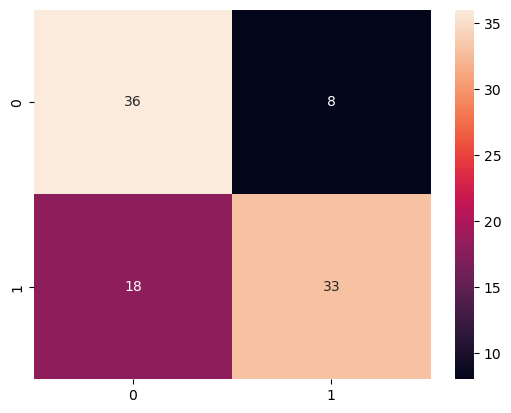

In [81]:
show_confusion_matrix(test_labels, y_pred)

# Random Forest Classifier

### Tune Hyper-Parameters for Random Forest

In [83]:
def tune_random_forest(search_space,max_iterations, training_data, training_labels, kfolds=5):
    print("Tuning Hyper-parameter for Random forest")
    def objective_(search_space):
        model = RandomForestClassifier(**search_space)
        cv_results = cross_val_score(model, X=training_data, y=training_labels, cv=kfolds,scoring="accuracy")
        accuracy = cv_results.mean()    
        return {"loss":(1-accuracy),"status":STATUS_OK}
    
    best_params = fmin(fn=objective_, space=search_space, algo=tpe.suggest, max_evals=max_iterations)    
    print("Hyper-parameter tuning is completed")
    return best_params


In [85]:
search_space = {
    "n_estimators":hp.uniformint("n_estimators",100,1000),
    "bootstrap":hp.choice("bootstrap",[True, False]),
    "max_depth": hp.uniformint("max_depth",10,100),
    "max_features":hp.choice("max_features",["sqrt", "log2", None]),
    
}
best_params = tune_random_forest(search_space=search_space, max_iterations=120, training_data=X, training_labels=y)

Tuning Hyper-parameter for Random forest
100%|██████████| 120/120 [11:52:01<00:00, 356.02s/trial, best loss: 0.24270996640537512]    
Hyper-parameter tuning is completed


In [86]:
best_parameters = space_eval(search_space, best_params)
best_parameters

{'bootstrap': True,
 'max_depth': 59,
 'max_features': 'sqrt',
 'n_estimators': 410}

In [87]:
lr = RandomForestClassifier(**best_parameters)
lr.fit(X, y)
y_pred = lr.predict(test_data)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        51

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Total accuracy: 1.0


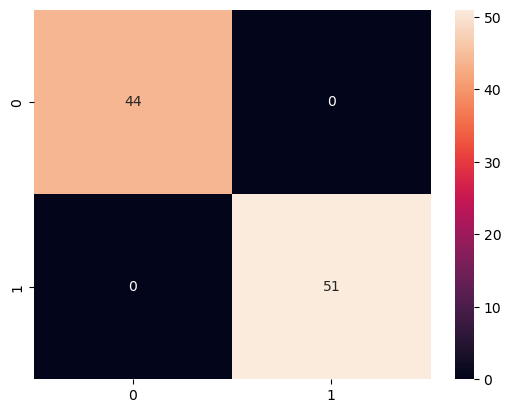

In [88]:
show_confusion_matrix(test_labels, y_pred)